In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import functools
import imageio
from skimage import data, transform

import jax
import flax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
from typing import Any, Callable
import optax

from datetime import datetime

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


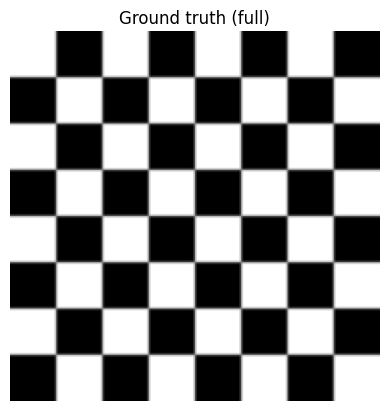

In [2]:
# load datasets
img = data.checkerboard()
H, W = img.shape
print(img)
img = img.astype(jnp.float32) / 255.0
plt.figure()
plt.title('Ground truth (full)')
plt.imshow(img, cmap = plt.cm.gray)
plt.axis('off')
plt.show()

# hold out half
x = np.linspace(-1, 1, W) # (x, y) \in [-1, 1]^2
y = np.linspace(-1, 1, H)
coords = np.stack(np.meshgrid(x, y, indexing='xy'), axis = -1)

#hold out half of the coords by shuffling indices
flat_coords = coords.reshape(-1, 2)
flat_vals = img.reshape(-1)

N = flat_vals.shape[0]
idx = np.arange(N)
rng = np.random.default_rng(seed=3)
rng.shuffle(idx)
train_idx = idx[:N//2]
test_idx = idx[N//2:]

coords_train = flat_coords[train_idx]
vals_train = flat_vals[train_idx]
coords_test = flat_coords[test_idx]
vals_test = flat_vals[test_idx]



In [3]:
# Build our network
class MLP(nn.Module):
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True

    @nn.compact
    def __call__(self, x):
        """
        Args:
            x: points to evaluate on
        """

        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()
        )

        if self.do_skip:
            skip_layer = self.net_depth // 2 #halfway through the network
        
        inputs = x # save non-passed parameters
        for i in range(self.net_depth):
            x = dense_layer(self.net_width)(x) # build dense layer -> forward pass
            x = self.activation(x)
            if self.do_skip:
                if i % skip_layer == 0 and i != 0:
                    x = jnp.concatenate([x, inputs], axis=-1)
        out = dense_layer(self.out_channel)(x)

        return out
    
def posenc(x, deg):
    """help the model learn high frequency details"""

    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)])
    pts_expanded = x[..., None, :]
    scales_expanded = scales[:, None]
    scaled_tensor = pts_expanded * scales_expanded
    flattened_pts = jnp.reshape(scaled_tensor, list(x.shape[:-1]) + [-1]) #build array w shape (shape[0:end-1], -1) = (N_pts, -1) = (N_pts, deg * D)
    safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))
    fourier_pts = safe_sin(jnp.concatenate([flattened_pts, flattened_pts + 0.5 * jnp.pi], axis = -1))
    return jnp.concatenate([x] + [fourier_pts], axis = -1)

class NeuralImage(nn.Module):
    """
    Wrapper around an arbitrary MLP architecture
    """

    posenc_deg: int = 7
    net_depth: int = 6
    net_width: int = 256
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth)
        def predict_img(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = nn.sigmoid(net_output[..., 0]) #on the output layer
            return image
        return predict_img(coords)

In [4]:
# define loss and training

def loss_fn(params, predictor, target, coords):
    image_pred = predictor({'params': params}, coords)
    loss = jnp.mean((image_pred - target)**2)
    return loss, image_pred

@jax.jit #just in time compilation for speed
def train_step(state, target, coords):
    """
    Args:
        state: current train state
        target: known image intensity values
        coords: positional coords across image
    """
    (loss, image_pred), grads = jax.value_and_grad(loss_fn, argnums=0, has_aux=True)(state.params, state.apply_fn, target, coords)
    state = state.apply_gradients(grads=grads) #ignoring paralleization for now
    return loss, state, image_pred

In [5]:
# instantiate training data and train

predictor = NeuralImage()

hparams = {'num_iters': 4000, 'lr_init': 1e-3, 'lr_final': 1e-5, 'batchsize': 2000}

params = predictor.init(jax.random.PRNGKey(3), coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)
for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(vals_train)), hparams['batchsize'], replace=False)
    loss, state, image = train_step(state, vals_train[batch, ...], coords_train[batch])
    if i % 1000 == 0:
        print(f"iteration {i}, loss={loss:.5f}")

iteration:   0%|          | 0/4000 [00:00<?, ?it/s]

iteration 0, loss=0.30440
iteration 1000, loss=0.00010
iteration 2000, loss=0.00004
iteration 3000, loss=0.00002


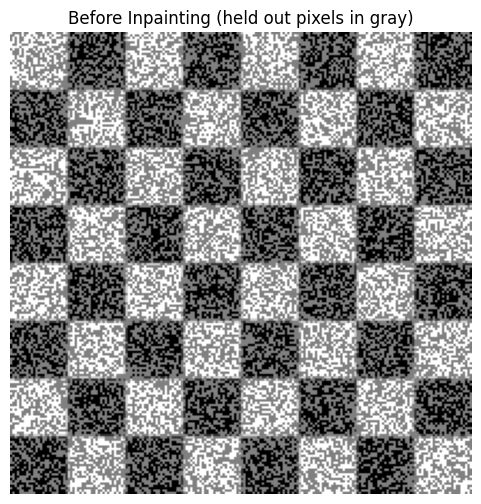

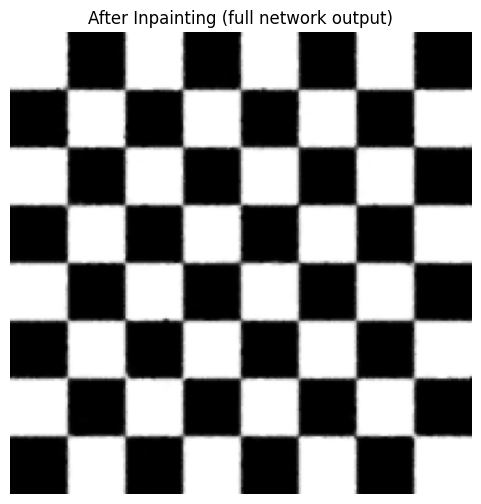

In [6]:
# ground truth (pixels held out)
masked_img = img.copy()
masked_img_flat = masked_img.reshape(-1)

fill_val = 0.5 #not black or white bc checkerboard is those colors
masked_img_flat[test_idx] = fill_val

masked_img = masked_img_flat.reshape(H, W)
plt.figure(figsize=(6, 6))
plt.title("Before Inpainting (held out pixels in gray)")
plt.imshow(masked_img, cmap='gray')
plt.axis('off')
plt.show()

# deep learning inpainting
full_image = predictor.apply({'params': state.params}, coords)
full_image = np.array(full_image)
plt.figure(figsize=(6,6))
plt.title("After Inpainting (full network output)")
plt.imshow(full_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()